<a href="https://colab.research.google.com/github/mmcastillo/al112248/blob/main/Unet_aneurismas_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Codigo para entrenar una U-NET con controles y pacientes con aneurismas
#M.I.B. Mario O. Mata-Castillo @08-2022

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
from google.colab import drive
drive.mount('/content/drive/');
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from scipy import ndimage
from sklearn.model_selection import train_test_split

Mounted at /content/drive/


In [ ]:
def resize_volume(img):
    # Set the desired depth
    desired_depth = 140
    desired_width = 560
    desired_height = 560
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [ ]:
#Carga conjunto de entrenamiento
ruta_TOF = '/content/drive/MyDrive/Doctorado/python/adam_subset/train_images/';
lista_archivos_TOF = os.listdir(ruta_TOF)
X =[]

for i, file in enumerate(lista_archivos_TOF):
    if file[-6:]=='nii.gz':
        data = nib.load(ruta_TOF + file)
        temp = data.get_fdata()
        temp = np.float32(temp)
        X.append(temp)
        
#Carga etiquetas de entrenamiento
ruta_mascaras = '/content/drive/MyDrive/Doctorado/python/adam_subset/train_tags/'; 
lista_archivos_mascaras = os.listdir(ruta_mascaras)
Y =[]

for i, file in enumerate(lista_archivos_mascaras):
    if file[-6:]=='nii.gz':
      data = nib.load(ruta_mascaras+ file)
      temp = data.get_fdata()
      temp = np.float32(temp)
      Y.append(temp)

In [ ]:
for i in range(len(X)):
  X[i] = resize_volume(X[i])

X = np.asarray(X)

for i in range(len(Y)):
  Y[i] = resize_volume(Y[i])

Y = np.asarray(Y)

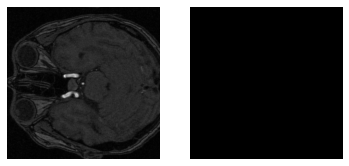

In [ ]:
corte = 40
plt.subplot(1,2,1)
plt.imshow(X[10][:,:,corte], cmap='gray')
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(Y[10][:,:,corte],cmap='gray')
plt.axis('off');

In [ ]:
def normalizar(volume):
  "Normalizar las intensidades de las imágenes de 0 a 1"
  volume = volume/np.max(volume) #Cambiar a 2^12
  return volume

In [ ]:
volume = normalizar(X)
print(volume.shape)


volume_tags = normalizar(Y)
print(volume_tags.shape)

del X,Y

(20, 560, 560, 140)


In [ ]:
img_patches = patchify(volume, (5, 32, 32, 32), step=32)
mask_patches = patchify(volume_tags, (5, 32, 32, 32), step=32)  
del volume,volume_tags

In [ ]:
np.unique(mask_patches[0,2,1,0,1,:,:,22])

In [ ]:
plt.subplot(121),
plt.imshow(img_patches[0,2,1,0,1,:,:,22],cmap='gray');
plt.subplot(122),
plt.imshow(mask_patches[0,2,1,0,1,:,:,22],cmap='gray');

In [ ]:
input_img = np.reshape(img_patches, (-1,img_patches.shape[5], img_patches.shape[6], img_patches.shape[7]))
input_mask = np.reshape(mask_patches, (-1,mask_patches.shape[5], mask_patches.shape[6], mask_patches.shape[7]))

print(input_img.shape)  # n_patches, # casos, x, y, z

del img_patches,mask_patches

In [ ]:
def conv_block(input, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv3D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    activation = 'softmax'

    outputs = Conv3D(1, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(f'activation function: {activation}')

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model = build_unet(( 32, 32, 32, 1))
print(f'model input shape: {model.input_shape}')

In [ ]:
from keras import backend as K

# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
LR = 0.001
optim = keras.optimizers.Adam(LR)

model.compile(optimizer=optim, loss=dice_coefficient_loss ,metrics = [dice_coefficient])
print(model.summary())

In [ ]:
train_img = np.expand_dims(input_img, axis=4)
print(train_img.shape)

train_mask = np.expand_dims(input_mask, axis=4)
print(train_mask.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask, test_size = 0.30, random_state = 0)
del train_img 
del train_mask

In [ ]:
print(model.input_shape)
print(X_train.shape)
print(model.output_shape)
print(y_train.shape)

In [ ]:
#Fit the model
model.fit(X_train, y_train, validation_split = 0.3, batch_size=32, epochs=100)

In [ ]:
y_pred=model.predict(X_test)
#y_pred = y_pred >= 0.5 
#y_pred = y_pred.astype(int)
print(y_pred.shape)
print(np.unique(y_pred))

In [ ]:
print(np.unique(y_test[38,:,:,26,:]))

In [ ]:
plt.subplot(1,3,1)
plt.imshow(X_test[38,:,:,26,0],cmap='gray');
plt.subplot(1,3,2)
plt.imshow(y_test[38,:,:,26,0],cmap='gray');
plt.subplot(1,3,3)
plt.imshow(y_pred[38,:,:,26,0],cmap='gray');